In [151]:
import numpy as np
import struct
import random

In [152]:
from scipy.io import loadmat
import torch
import torchvision.transforms as T

mnist = loadmat('./mnist.mat') # change the file path according to the path where you put mnist.mat on your Google Drive.

# convert data to torch, normalize and reshape
data = torch.reshape(torch.from_numpy(mnist['traindata']).to(torch.float)/255.0 - 0.5, (mnist['traindata'].shape[0], 1, 28, 28))
testdata = torch.reshape(torch.from_numpy(mnist['testdata']).to(torch.float)/255.0 - 0.5, (mnist['testdata'].shape[0], 1, 28, 28))

trainlabels = torch.from_numpy(mnist['trainlabels'].ravel()[:10000])
validlabels = torch.from_numpy(mnist['trainlabels'].ravel()[59000:])

resize = T.Resize((14,14))
data = resize(data)
testdata = resize(testdata)
traindata = data[:10000]
validdata = data[59000:]


print(traindata.shape)
print(trainlabels.shape)
print(validdata.shape)
print(validlabels.shape)
print(testdata.shape)

torch.Size([10000, 1, 14, 14])
torch.Size([10000])
torch.Size([1000, 1, 14, 14])
torch.Size([1000])
torch.Size([10000, 1, 14, 14])


In [153]:
from tqdm import tqdm
import torch

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  error = 0
  correct = 0
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    model.eval()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
  error = 100. * (1 - correct / len(train_loader.dataset))
  return error




def test(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item() * data.size(0)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  error = 100. * (1 - correct / len(test_loader.dataset))
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      test_loss, correct, len(test_loader.dataset), accuracy))
  return error


In [154]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch

mnist_train = TensorDataset(traindata, trainlabels)
mnist_valid = TensorDataset(validdata, validlabels)
mnist_train_loader = DataLoader(mnist_train, batch_size=128)
mnist_valid_loader = DataLoader(mnist_valid, batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epoch = 10

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16*4, 10)



  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, 16*4)
    x = self.fc1(x)
    return x

cnn_mnist = CNN().to(device) 

In [155]:
from time import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_mnist.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
test_error = []
train_error = []
start = time()
for i in range(n_epoch):
  error = train(cnn_mnist, device, mnist_train_loader, optimizer, criterion)
  acc =test(cnn_mnist, device, mnist_valid_loader, criterion)
  test_error.append(acc)
  train_error.append(error)
end = time()
print('time:', end-start)


100%|██████████| 79/79 [00:00<00:00, 427.75it/s]


Test set: Average loss: 1.2815, Accuracy: 768/1000 (77%)


100%|██████████| 79/79 [00:00<00:00, 477.13it/s]


Test set: Average loss: 0.4827, Accuracy: 870/1000 (87%)


100%|██████████| 79/79 [00:00<00:00, 490.06it/s]


Test set: Average loss: 0.3125, Accuracy: 913/1000 (91%)


100%|██████████| 79/79 [00:00<00:00, 487.03it/s]


Test set: Average loss: 0.2501, Accuracy: 938/1000 (94%)


100%|██████████| 79/79 [00:00<00:00, 456.36it/s]


Test set: Average loss: 0.2148, Accuracy: 949/1000 (95%)


100%|██████████| 79/79 [00:00<00:00, 482.06it/s]


Test set: Average loss: 0.1931, Accuracy: 955/1000 (96%)


100%|██████████| 79/79 [00:00<00:00, 485.35it/s]


Test set: Average loss: 0.1791, Accuracy: 955/1000 (96%)


100%|██████████| 79/79 [00:00<00:00, 466.52it/s]


Test set: Average loss: 0.1686, Accuracy: 958/1000 (96%)


100%|██████████| 79/79 [00:00<00:00, 468.07it/s]


Test set: Average loss: 0.1604, Accuracy: 962/1000 (96%)


100%|██████████| 79/79 [00:00<00:00, 445.87it/s]

Test set: Average loss: 0.1537, Accuracy: 964/1000 (96%)
time: 1.7907872200012207


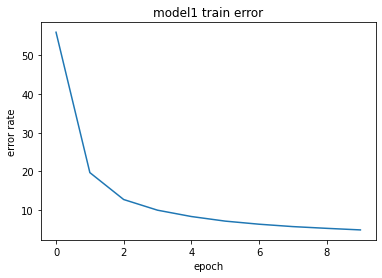

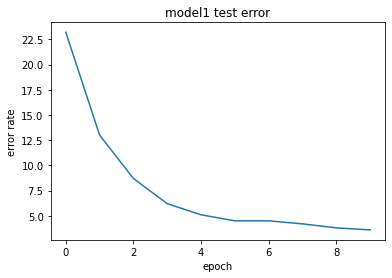

In [156]:
import matplotlib.pyplot as plt
plt.plot(train_error)
plt.title('model1 train error')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.savefig('model1 train error.png')
plt.show()
plt.plot(test_error)
plt.title('model1 test error')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.savefig('model1 test error.png')
plt.show()

In [157]:
class CNN1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(1152, 10)



  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = x.view(-1, 1152)
    x = self.fc1(x)
    return x

cnn_mnist1 = CNN1().to(device) 

In [158]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_mnist1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
test_error = []
train_error = []

for i in range(n_epoch):
  error = train(cnn_mnist1, device, mnist_train_loader, optimizer, criterion)
  start = time()
  acc =test(cnn_mnist1, device, mnist_valid_loader, criterion)
  end = time()
  print('time:', end-start)
  test_error.append(acc)
  train_error.append(error)



100%|██████████| 79/79 [00:00<00:00, 580.34it/s]


Test set: Average loss: 0.5975, Accuracy: 911/1000 (91%)
time: 0.007803678512573242


100%|██████████| 79/79 [00:00<00:00, 610.83it/s]


Test set: Average loss: 0.2993, Accuracy: 934/1000 (93%)
time: 0.007651329040527344


100%|██████████| 79/79 [00:00<00:00, 620.00it/s]


Test set: Average loss: 0.2253, Accuracy: 947/1000 (95%)
time: 0.006420612335205078


100%|██████████| 79/79 [00:00<00:00, 586.58it/s]


Test set: Average loss: 0.1909, Accuracy: 955/1000 (96%)
time: 0.007692575454711914


100%|██████████| 79/79 [00:00<00:00, 629.88it/s]


Test set: Average loss: 0.1711, Accuracy: 964/1000 (96%)
time: 0.007451057434082031


100%|██████████| 79/79 [00:00<00:00, 606.75it/s]


Test set: Average loss: 0.1580, Accuracy: 961/1000 (96%)
time: 0.007108449935913086


100%|██████████| 79/79 [00:00<00:00, 542.02it/s]


Test set: Average loss: 0.1491, Accuracy: 965/1000 (96%)
time: 0.007023811340332031


100%|██████████| 79/79 [00:00<00:00, 604.04it/s]


Test set: Average loss: 0.1425, Accuracy: 967/1000 (97%)
time: 0.007817506790161133


100%|██████████| 79/79 [00:00<00:00, 579.29it/s]


Test set: Average loss: 0.1373, Accuracy: 968/1000 (97%)
time: 0.006600856781005859


100%|██████████| 79/79 [00:00<00:00, 537.00it/s]

Test set: Average loss: 0.1329, Accuracy: 972/1000 (97%)
time: 0.007752895355224609


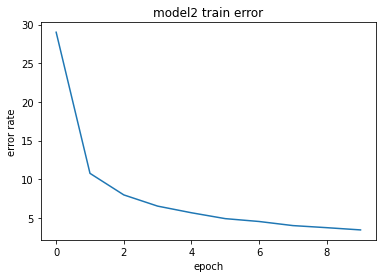

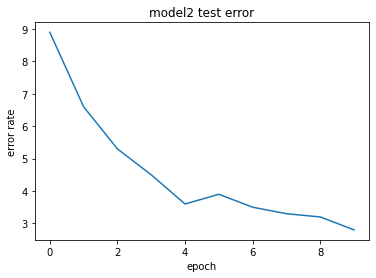

In [159]:
import matplotlib.pyplot as plt
plt.plot(train_error)
plt.title('model2 train error')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.savefig('model2 train error.png')
plt.show()
plt.plot(test_error)
plt.title('model2 test error')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.savefig('model2 test error.png')
plt.show()